# Imports

In [1]:
# pyright: reportUnknownArgumentType=false, reportCallIssue=false, reportAttributeAccessIssue=false, reportOptionalSubscript=false, reportArgumentType=false
from rich.console import Console
from rich.table import Table
from rich.theme import Theme
from rich.logging import RichHandler

from finesse.model import Model
from finesse.analysis.actions.axes import Noxaxis, Xaxis
from finesse.solutions import SeriesSolution
from finesse.detectors import PowerDetector
from finesse.analysis.actions import (
    TemporaryParameters,
    Change,
    Maximize,
    Minimize,
    Series,
    FrequencyResponse,
    Noxaxis,
)
from finesse.components import Mirror, SignalGenerator
from finesse.detectors import QuantumNoiseDetector
from finesse.exceptions import ModelMissingAttributeError

from pathlib import Path
from typing import NamedTuple
import re

from matplotlib.axes import Axes
from matplotlib.pyplot import figure, show


from numpy import (
    linspace,
    geomspace,
    pi,
    angle,
    diff,
    loadtxt,
    load,
    sqrt,
)

In [2]:
from gettext import install
from logging import getLogger, basicConfig, INFO, WARNING

In [21]:
from utils import (
    compute_solutions,
    process_solution,
    DisplayData,
    display_displaydata,
    fix_dark_fringe,
    get_QNLS,
)
from MaskedReadoutDC import MaskedReadoutDC

In [22]:
install(__name__)
theme = Theme(
    {
        "strong": "cyan underline",
        "result": "red bold",
    }
)
console = Console(theme=theme)
basicConfig(
    level=WARNING,
    format="%(message)s",
    datefmt="[%X]",
    handlers=[RichHandler(console=console, rich_tracebacks=True)],
)
logger = getLogger(__name__)

## Paramètres généraux

In [23]:
C_POWER = 25  # en Whatt
C_DARK_FRINGE = 8e-3  # en Whatt
C_PRECISION = 100  # number of points in simulation
C_DEBUG = False  # if some figure should be displayed

## Modèle simplifié de Virgo

In [24]:
model: Model = Model()
model.phase_config(zero_k00=False, zero_tem00_gouy=True)

model.parse(Path("model.kat").read_text())
model.lambda0 = model.get("wavelength")
model.SR.xbeta = 2e-6  # yaw rotation of SR
model.laser.P = C_POWER

if C_DEBUG:
    # Show model elements
    graph = model.plot_graph()
    show()

In [25]:
try:
    model.get("B1")
    logger.info("B1 already exists")
except ModelMissingAttributeError:
    model.add(
        MaskedReadoutDC(
            "B1",
            output_detectors=True,
            optical_node=model.SDB1.p2.o,
        )
    )
    logger.info("Adding B1 to the model")

[17:34:02] INFO     Adding B1 to the model                                                         ]8;id=576034;file:///tmp/ipykernel_35177/2923683328.py\2923683328.py]8;;\:]8;id=441493;file:///tmp/ipykernel_35177/2923683328.py#12\12]8;;\

In [26]:
result = model.run(
    TemporaryParameters(
        Series(
            Change(
                {
                    "SR.misaligned": True,
                    "PR.misaligned": True,
                }
            ),
            Maximize(
                model.get("NE_p1"),
                model.get("NORTH_ARM.DC"),
                bounds=[-180, 180],
                tol=1e-14,
            ),
            Maximize(
                model.get("WE_p1"),
                model.get("WEST_ARM.DC"),
                bounds=[-180, 180],
                tol=1e-14,
            ),
            Minimize(
                model.get("SR_p2"),
                model.get("MICH.DC"),
                bounds=[-180, 180],
                tol=1e-14,
            ),
            Change(
                {
                    "PR.misaligned": False,
                }
            ),
            Maximize(
                model.get("PR_p2"),
                model.get("PRCL.DC"),
                bounds=[-180, 180],
                tol=1e-14,
            ),
            Change(
                {
                    "SR.misaligned": False,
                }
            ),
            Maximize(
                model.get("B1_DC"),
                model.get("SRCL.DC"),
                bounds=[-180, 180],
                tol=1e-14,
            ),
            Change(
                {
                    "SRCL.DC": -90,
                },
                relative=True,
            ),
        ),
        exclude=[
            "NE.phi",
            "NI.phi",
            "WE.phi",
            "WI.phi",
            "SR.phi",
            "PR.phi",
            "NORTH_ARM.DC",
            "WEST_ARM.DC",
            "DARM.DC",
            "MICH.DC",
            "PRCL.DC",
            "SRCL.DC",
            "SR.misaligned",
        ],
    ),
)
model.B1.select_mask(exclude=(0, 0))
model.modes(maxtem=3)

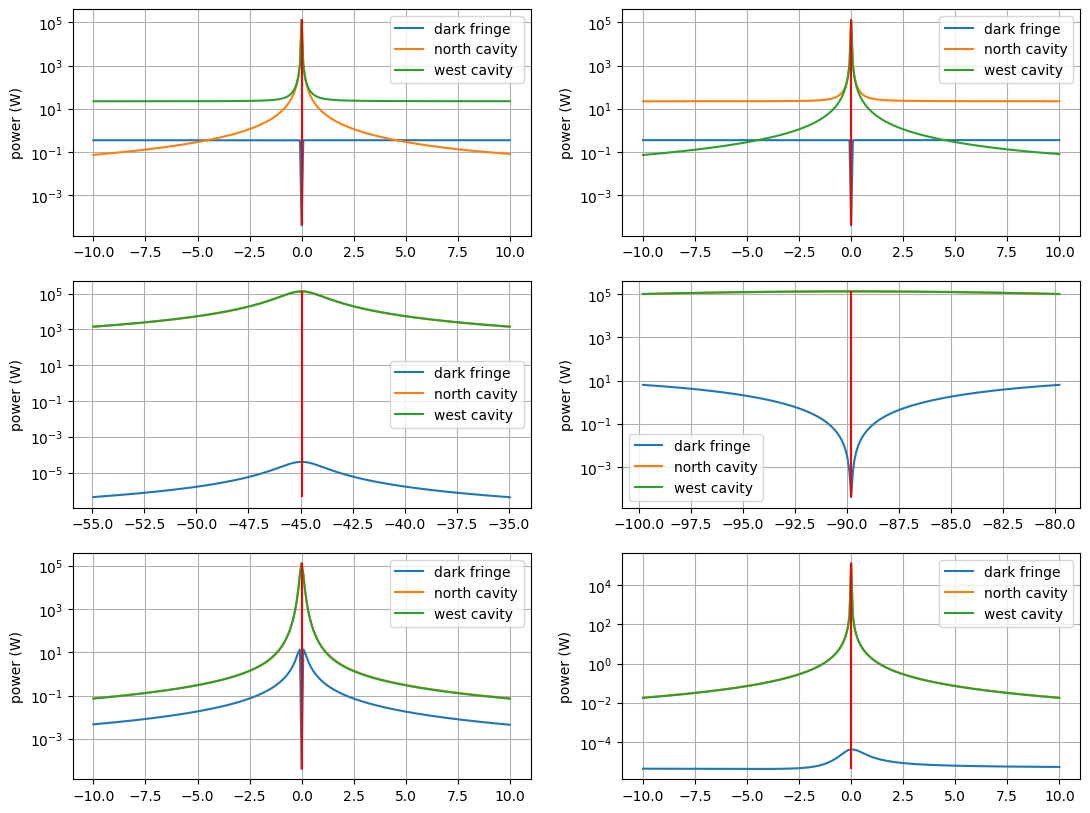

0.00109100341796875 with 17 steps give 0.007989 mW on the dark fringe

In [27]:
logger.setLevel(WARNING)
for handler in logger.handlers:
    handler.setLevel(WARNING)
display_displaydata(
    model,
    [
        DisplayData("NORTH_ARM", 10),
        DisplayData("WEST_ARM", 10),
        DisplayData("PRCL", 10),
        DisplayData("MICH", 10),
        DisplayData("DARM", 10),
        DisplayData("CARM", 10),
    ],
)
number, power = fix_dark_fringe(model, C_DARK_FRINGE)
console.print(
    "[result]{dof}[/result] with [result]{number} steps[/result] give [result]{power:.6f} mW[/result] on the [strong]dark fringe[/strong]".format(
        number=number,
        dof=model.DARM.DC,
        power=power,
    )
)
logger.setLevel(INFO)
for handler in logger.handlers:
    handler.setLevel(INFO)

In [28]:
solution = model.run(Noxaxis())
console = Console()
table = Table(title="Puissances dans l'interferomètre")
table.add_column("position", justify="left", style="white")
table.add_column("puissance (W)", justify="left", style="cyan")

table.add_row("Injection", str(model.get("laser").P.eval()))
table.add_row("PR", str(solution["PR_p1"]))
table.add_row(
    "cavité de recyclage de puissance", str(solution["PR_p2"])
)
table.add_row("cavité ouest", str(solution["WE_p1"]))
table.add_row("cavité nord", str(solution["NE_p1"]))
table.add_row("frange noire", str(solution["SR_p2"]))
table.add_row("SNEB", str(solution["SNEB_DC"]))
table.add_row("SWEB", str(solution["SWEB_DC"]))
table.add_row("SDB1", str(solution["SDB1_DC"]))

console.print(table)

table = Table(title="DOF dans l'interferomètre")
table.add_column("nom", justify="left", style="white")
table.add_column("valeur", justify="left", style="magenta")

table.add_row("Bras nord", str(model.get("NORTH_ARM.DC")))
table.add_row("Bras ouest", str(model.get("WEST_ARM.DC")))
table.add_row("PR", str(model.get("PRCL.DC")))
table.add_row("SR", str(model.get("SRCL.DC")))
table.add_row("MICH", str(model.get("MICH.DC")))

console.print(table)

console = Console(theme=theme)
table = Table(title="")
table.add_column("nom", justify="left", style="white")
table.add_column("valeur", justify="left", style="cyan")
for i in range(1, model.west_arm.info_parameter_table().table.shape[0]):
    table.add_row(
        str(model.west_arm.info_parameter_table().table[i, 0]),
        str(model.west_arm.info_parameter_table().table[i, 1]),
    )
console.print(table)

             Puissances dans l'interferomètre              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ position                         ┃ puissance (W)        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ Injection                        │ 25.0                 │
│ PR                               │ 3.529110765817165    │
│ cavité de recyclage de puissance │ 965.3742229980147    │
│ cavité ouest                     │ 135259.4179445027    │
│ cavité nord                      │ 133191.31054722168   │
│ frange noire                     │ 0.007990521602279099 │
│ SNEB                             │ 0.5978209233893383   │
│ SWEB                             │ 0.5815451496990748   │
│ SDB1                             │ 0.007989394938733177 │
└──────────────────────────────────┴──────────────────────┘

       DOF dans l'interferomètre        
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ nom        ┃ valeur                  ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Bras nord  │ 6.592588499188424e-06   │
│ Bras ouest │ -5.8479547500610346e-05 │
│ PR         │ -44.946681098699614     │
│ SR         │ -135.0960161170923      │
│ MICH       │ -89.79029219055182      │
└────────────┴─────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ nom                   ┃ valeur                          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ FSR                   │ 49968.74091606107               │
│ Loss                  │ 0.013848722846499961            │
│ Finesse               │ 450.5516190359727               │
│ FWHM                  │ 110.90569605093683              │
│ Storage time          │ 0.0028700950223295757           │
│ Pole                  │ 55.45284802546841               │
│ Round trip length     │ 5999.6                          │
│ Waist size            │ [0.00968668 0.00968668]         │
│ Waist position        │ [-1363.71492094 -1363.71492094] │
│ Stability (m-factor)  │ [0.7409226 0.7409226]           │
│ Stability (g-factor)  │ [0.8704613 0.8704613]           │
│ Round trip gouy phase │ [317.81006617 317.81006617]     │
│ Mode separation       │ [5856.04964666 5856.04964666]   │
│ Resolution            │ [52.80206387 52.80206387]       │
│ Stable                │ True                            │
│ Critically stable     │ False                           │
└───────────────────────┴─────────────────────────────────┘

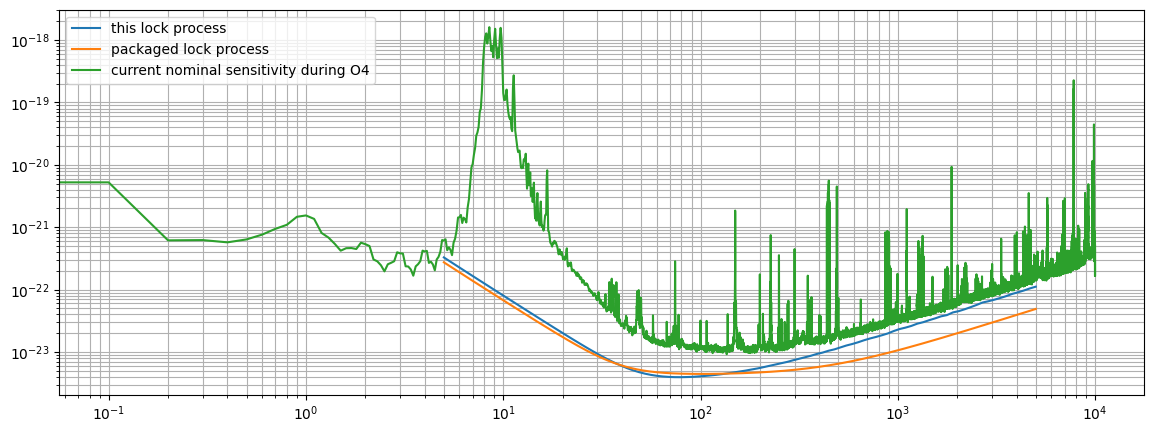

/home/demagny/codes/python/finesse/finesse-simulation-04/.venv/lib/python3.13/site-packages/finesse/analysis/actions/base.py:157: UserWarning: Signal frequency (fsig) was set to None but simulation needs it. Setting default value of 1 Hz
  self.__sim.__enter__()


KeyError: 'B1.DC.o'

In [30]:
solution = get_QNLS(model, 5, 5000, C_PRECISION)

B1_detector = model.B1.DC

QNLS = load("sensitivities/finesse-virgo.npy")
current_O4_sensitivity_ASD = loadtxt(
    "sensitivities/O4_nominal_reference.txt"
)

Figure = figure(figsize=(14, 5))
_ = Figure.gca().loglog(
    solution.x1, abs(solution["NSR_with_RP"]), label="this lock process"
)
_ = Figure.gca().loglog(
    QNLS[0],
    QNLS[1],
    label="packaged lock process",
)
_ = Figure.gca().loglog(
    current_O4_sensitivity_ASD[0],
    abs(current_O4_sensitivity_ASD[1]),
    label="current nominal sensitivity during O4",
)
_ = Figure.gca().legend()
Figure.gca().grid(True, "both", "both")
show()

solution = model.run(
    FrequencyResponse(
        geomspace(5, 10000, C_PRECISION), ["DARM"], [B1_detector]
    )
)
maximum_amplitude_step: float = max(
    abs(diff(angle(solution[B1_detector, "DARM"])))
)

pole_index = round(
    mean(
        where(
            abs(angle(solution[B1_detector, "DARM"]) + pi / 4)
            < maximum_amplitude_step * 2
        )
    )
)  # find the index where the curve is the closest to -45°
console.print(
    "Le [strong]pôle[/strong] de la fonction de transfert [strong]DARM[/strong] est à [result]{:.1f}[/result] Hz".format(
        solution.f[pole_index]
    )
)


table = Table(title="Position des différents miroirs")
table.add_column("miroir", justify="left", style="white")
table.add_column("offset (°)", justify="left", style="white")
table.add_column("offset (m)", justify="left", style="white")

for name in [
    "NE",
    "NE_AR",
    "NI",
    "NI_AR",
    "WE",
    "WE_AR",
    "WI",
    "WI_AR",
    "PR",
    "PR_AR",
    "SR",
    "SR_AR",
]:
    element: Mirror = model.get(name)
    table.add_row(
        str(element.name),
        str(element.phi.eval()),
        str(element.phi.eval() * model.lambda0 / 180),
    )

console.print(table)

## Comparaison avec Optickle

In [ ]:
model.SNEB.phi = model.NE.phi - 45
model.SWEB.phi = model.WE.phi - 45
model.SDB1.phi = model.SR.phi + 45

quad_tf: dict[str, SeriesSolution] = dict()
in_tf: dict[str, SeriesSolution] = dict()

for bench_name in ["SNEB", "SWEB", "SDB1"]:
    quad_tf[bench_name] = model.run(
        FrequencyResponse(
            geomspace(5, 10000, C_PRECISION),
            ["{}_z".format(bench_name)],
            [B1_detector],
        )
    )

quad_tf["DARM"] = model.run(
    FrequencyResponse(
        geomspace(5, 10000, C_PRECISION), ["DARM"], [B1_detector]
    )
)

model.SNEB.phi = model.NE.phi
model.SWEB.phi = model.WE.phi
model.SDB1.phi = model.SR.phi

for bench_name in ["SNEB", "SWEB", "SDB1"]:
    in_tf[bench_name] = model.run(
        FrequencyResponse(
            geomspace(5, 10000, C_PRECISION),
            ["{}_z".format(bench_name)],
            [B1_detector],
        )
    )

in_tf["DARM"] = model.run(
    FrequencyResponse(
        geomspace(5, 10000, C_PRECISION), ["DARM"], [B1_detector]
    )
)

modelisation_file = Path("TF results/TEM00_2025-05-22.npy")

TEM00_TFs = load(modelisation_file, allow_pickle=True)
TEM00_TF_in = TEM00_TFs[0]
TEM00_TF_qu = TEM00_TFs[1]

### En fonction de la phase

In [ ]:
Figure = figure(figsize=(7, 5))
ax = Figure.gca()
_ = ax.loglog(
    quad_tf["DARM"].f,
    abs(quad_tf["DARM"][B1_detector, "DARM"]),
    label="High order mode",
)
_ = ax.loglog(
    TEM00_TF_qu["DARM"].f,
    abs(TEM00_TF_qu["DARM"][B1_detector, "DARM"]),
    label="TEM00",
)
_ = ax.set_ylabel("$\\frac{W}{\\sqrt{Hz}}$")
_ = ax.set_xlabel("Frequencies (Hz)")
_ = ax.set_title("Transfer function module comparison for DARM")
_ = ax.legend()
ax.grid(True, "both", "both")

Figure = figure(figsize=(7, 5))
ax = Figure.gca()
_ = ax.semilogx(
    quad_tf["DARM"].f,
    angle(quad_tf["DARM"][B1_detector, "DARM"]) * 180 / pi,
    label="High order mode",
)
_ = ax.semilogx(
    TEM00_TF_qu["DARM"].f,
    angle(TEM00_TF_qu["DARM"][B1_detector, "DARM"]) * 180 / pi,
    label="TEM00",
)
_ = ax.set_title("Comparison of transfer function phase for DARM")
_ = ax.set_ylabel("phase (°)")
_ = ax.set_xlabel("Frequencies (Hz)")
_ = ax.hlines(
    [-45],
    min(quad_tf["DARM"].f),
    max(quad_tf["DARM"].f),
    colors="red",
    label="45°",
)
_ = ax.legend()
ax.grid(True, "both", "both")

for bench_name in ["SNEB", "SWEB", "SDB1"]:
    in_index = 0
    if bench_name == "SDB1":
        in_index = 0
    quad_index = (1 + in_index) % 2
    Figure = figure(figsize=(14, 5))
    _ = Figure.suptitle(
        "Comparison of transfer function module for {}".format(
            bench_name
        )
    )
    ax = Figure.add_subplot(1, 2, 1)
    _ = ax.loglog(
        quad_tf[bench_name].f,
        abs(quad_tf[bench_name][B1_detector, "{}_z".format(bench_name)])
        / abs(quad_tf["DARM"][B1_detector, "DARM"])
        / model.space_NI_NE.L.eval(),
        label="High order mode",
    )
    _ = ax.loglog(
        TEM00_TF_qu[bench_name].f,
        abs(
            TEM00_TF_qu[bench_name][
                B1_detector, "{}_z".format(bench_name)
            ]
        )
        / abs(TEM00_TF_qu["DARM"][B1_detector, "DARM"])
        / model.space_NI_NE.L.eval(),
        label="TEM00",
    )
    _ = ax.set_ylabel("$\\frac{m}{m}$")
    _ = ax.set_xlabel("Frequencies (Hz)")
    _ = ax.set_title("$K_P$")
    _ = ax.legend()
    ax.grid(True, "both", "both")
    ax = Figure.add_subplot(1, 2, 2)
    _ = ax.loglog(
        in_tf[bench_name].f,
        abs(in_tf[bench_name][B1_detector, "{}_z".format(bench_name)])
        / abs(in_tf["DARM"][B1_detector, "DARM"])
        / model.space_NI_NE.L.eval(),
        label="High order mode",
    )
    _ = ax.loglog(
        TEM00_TF_in[bench_name].f,
        TEM00_TF_in[bench_name][B1_detector, "{}_z".format(bench_name)]
        / abs(TEM00_TF_in["DARM"][B1_detector, "DARM"])
        / model.space_NI_NE.L.eval(),
        label="TEM00",
    )
    _ = ax.set_ylabel("$\\frac{m}{m}$")
    _ = ax.set_xlabel("Frequencies (Hz)")
    _ = ax.set_title("$K_n$")
    _ = ax.legend()
    ax.grid(True, "both", "both")
    console.print()

In [ ]:
for bench_name in ["SNEB", "SWEB", "SDB1"]:
    Figure = figure(figsize=(7, 5))
    ax = Figure.gca()
    _ = ax.set_title(
        "Comparison of transfer function module for {}".format(
            bench_name
        )
    )
    _ = ax.loglog(
        quad_tf[bench_name].f,
        sqrt(
            (
                abs(
                    quad_tf[bench_name][
                        B1_detector, "{}_z".format(bench_name)
                    ]
                )
                / abs(quad_tf["DARM"][B1_detector, "DARM"])
                / model.space_NI_NE.L.eval()
            )
            ** 2
            + (
                abs(
                    in_tf[bench_name][
                        B1_detector, "{}_z".format(bench_name)
                    ]
                )
                / abs(in_tf["DARM"][B1_detector, "DARM"])
                / model.space_NI_NE.L.eval()
            )
            ** 2
        ),
        label="High order mode",
    )
    _ = ax.loglog(
        TEM00_TF_qu[bench_name].f,
        sqrt(
            (
                abs(
                    TEM00_TF_qu[bench_name][
                        B1_detector, "{}_z".format(bench_name)
                    ]
                )
                / abs(TEM00_TF_qu["DARM"][B1_detector, "DARM"])
                / model.space_NI_NE.L.eval()
            )
            ** 2
            + (
                abs(
                    TEM00_TF_in[bench_name][
                        B1_detector, "{}_z".format(bench_name)
                    ]
                )
                / abs(TEM00_TF_in["DARM"][B1_detector, "DARM"])
                / model.space_NI_NE.L.eval()
            )
            ** 2
        ),
        label="TEM00",
    )
    _ = ax.set_ylabel("$\\frac{m}{m}$")
    _ = ax.set_xlabel("Frequencies (Hz)")
    _ = ax.set_title(
        "Sum of the module of the transfer function for {}".format(
            bench_name
        )
    )
    _ = ax.legend()
    ax.grid(True, "both", "both")

### En fonction de la simulation

In [ ]:
for bench_name in ["SNEB", "SWEB", "SDB1"]:
    in_index = 0
    if bench_name == "SDB1":
        in_index = 0
    quad_index = (1 + in_index) % 2
    Figure = figure(figsize=(14, 5))
    _ = Figure.suptitle(
        "Comparaison des fonctions de transfert pour {}".format(
            bench_name
        )
    )
    ax = Figure.add_subplot(1, 2, 1)
    _ = ax.loglog(
        quad_tf[bench_name].f,
        abs(quad_tf[bench_name][B1_detector, "{}_z".format(bench_name)])
        / abs(quad_tf["DARM"][B1_detector, "DARM"])
        / model.space_NI_NE.L.eval(),
        label="Quadrature de phase",
    )
    _ = ax.loglog(
        in_tf[bench_name].f,
        abs(in_tf[bench_name][B1_detector, "{}_z".format(bench_name)])
        / abs(in_tf["DARM"][B1_detector, "DARM"])
        / model.space_NI_NE.L.eval(),
        label="En phase",
    )
    _ = ax.set_title("High order mode")
    _ = ax.legend()
    ax.grid(True, "both", "both")
    ax = Figure.add_subplot(1, 2, 2)
    _ = ax.loglog(
        TEM00_TF_qu[bench_name].f,
        abs(
            TEM00_TF_qu[bench_name][
                B1_detector, "{}_z".format(bench_name)
            ]
        )
        / abs(TEM00_TF_qu["DARM"][B1_detector, "DARM"])
        / model.space_NI_NE.L.eval(),
        label="Quadrature de phase",
    )
    _ = ax.loglog(
        TEM00_TF_in[bench_name].f,
        abs(
            TEM00_TF_in[bench_name][
                B1_detector, "{}_z".format(bench_name)
            ]
        )
        / abs(TEM00_TF_in["DARM"][B1_detector, "DARM"])
        / model.space_NI_NE.L.eval(),
        label="En phase",
    )
    _ = ax.set_title("TEM00")
    _ = ax.legend()
    ax.grid(True, "both", "both")
    show()

### En fonction du module/phase

In [ ]:
for bench_name in ["SNEB", "SWEB", "SDB1"]:
    Figure = figure(figsize=(14, 5))
    _ = Figure.suptitle(
        "Comparaison des fonctions de transfert pour {}".format(
            bench_name
        )
    )
    ax = Figure.add_subplot(1, 2, 1)
    _ = ax.loglog(
        quad_tf[bench_name].f,
        abs(quad_tf[bench_name][B1_detector, "{}_z".format(bench_name)])
        / abs(quad_tf["DARM"][B1_detector, "DARM"])
        / model.space_NI_NE.L.eval(),
        label="Quadrature de phase",
    )
    _ = ax.loglog(
        in_tf[bench_name].f,
        abs(in_tf[bench_name][B1_detector, "{}_z".format(bench_name)])
        / abs(in_tf["DARM"][B1_detector, "DARM"])
        / model.space_NI_NE.L.eval(),
        label="En phase",
    )
    _ = ax.set_title("Module")
    _ = ax.legend()
    ax.grid(True, "both", "both")
    ax = Figure.add_subplot(1, 2, 2)
    _ = ax.semilogx(
        quad_tf[bench_name].f,
        angle(
            quad_tf[bench_name][B1_detector, "{}_z".format(bench_name)]
        )
        * 180
        / pi,
        label="Quadrature de phase",
    )
    _ = ax.semilogx(
        in_tf[bench_name].f,
        angle(in_tf[bench_name][B1_detector, "{}_z".format(bench_name)])
        * 180
        / pi,
        label="En phase",
    )
    _ = ax.set_title("Finesse")
    _ = ax.legend()
    ax.grid(True, "both", "both")
    show()

In [ ]:
modes = model.modes()
for mode in modes:
    print(mode)
    name = "B1_power_{}_{}".format(*mode)
    model.add(PowerDetector(name, model.SDB1.p2.o))
    temp_modes = [list(mode) for mode in modes]
    temp_modes.remove(list(mode))
    model.get(name).select_mask(temp_modes)

result = model.run(Noxaxis())

In [ ]:
table = Table()
table.add_column("Mode")
table.add_column("Power (W)")

somme = 0
outputs: list[str] = []
for mode in modes:
    name = "B1_power_{}_{}".format(*mode)
    table.add_row("{}, {}".format(*mode), "{}".format(result[name]))
    somme += result[name]

table.add_row("Total", "{}".format(somme))
console.print(table)
console.print(result["SDB1_DC"])

In [ ]:
model.B1.